In [1]:

%matplotlib widget


In [2]:

from typing import Union

import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
class Render:
    def __init__(self, target: Union[list, tuple, np.ndarray], forbidden: Union[list, tuple, np.ndarray],
                 size=5):
        """ Render 类的构造函数

        :param target:目标点的位置
        :param forbidden:障碍物区域位置
        :param size:网格世界的size 默认为 5x5
        """
        # 初始化
        self.agent = None
        self.target = target
        self.forbidden = forbidden
        self.size = size
        self.fig = plt.figure(figsize=(5, 5), dpi=self.size * 20)
        self.ax = plt.gca()
        self.ax.xaxis.set_ticks_position('top')
        self.ax.invert_yaxis()
        self.ax.xaxis.set_ticks(range(0, size + 1))
        self.ax.yaxis.set_ticks(range(0, size + 1))
        self.ax.grid(True, linestyle="-", color="gray", linewidth="1", axis='both')
        self.ax.tick_params(bottom=False, left=False, right=False, top=False, labelbottom=False, labelleft=False,
                            labeltop=False)
        # 绘制网格世界的state index 以及grid边框的标号
        # index = 0
        for y in range(size):
            self.write_word(pos=(-0.6, y), word=str(y), size_discount=0.8)
            self.write_word(pos=(y, -0.6), word=str(y), size_discount=0.8)
            # for x in range(size):
            #     self.write_word(pos=(x, y), word="s" + str(index), size_discount=0.65)
            #     index += 1
        # 填充障碍物和目标格子
        for pos in self.forbidden:
            self.fill_block(pos=pos)
        self.fill_block(pos=self.target, color='darkturquoise')
        self.trajectory = []
        self.agent = patches.Arrow(-10, -10, 0.4, 0, color='red', width=0.5)
        self.ax.add_patch(self.agent)

    def fill_block(self, pos: Union[list, tuple, np.ndarray], color: str = '#EDB120', width=1.0,
                   height=1.0) -> patches.RegularPolygon:
        """
        对指定pos的网格填充颜色
        :param width:
        :param height:
        :param pos: 需要填充的网格的左下坐标
        :param color: 填充的颜色 默认为‘EDB120’表示 forbidden 格子 ,‘#4DBEEE’表示 target 格子
        :return: Rectangle对象
        """
        return self.ax.add_patch(
            patches.Rectangle((pos[0], pos[1]),
                              width=1.0,
                              height=1.0,
                              facecolor=color,
                              fill=True,
                              alpha=0.90,
                              ))

    def draw_random_line(self, pos1: Union[list, tuple, np.ndarray], pos2: Union[list, tuple, np.ndarray]) -> None:
        """
        在pos1 和pos2之间生成一条线条，这条线条会在pos1和pos2之间产生随机偏移
        :param pos1: 起点所在位置的坐标
        :param pos2: 终点所在位置的坐标
        :return:None
        """
        offset1 = np.random.uniform(low=-0.1, high=0.1, size=1)[0]
        offset2 = np.random.uniform(low=-0.05, high=0.05, size=1)[0]
        x = [pos1[0] + 0.5, pos2[0] + 0.5]
        y = [pos1[1] + 0.5, pos2[1] + 0.5]
        if pos1[0] == pos2[0]:
            x = [x[0] + offset1, x[1]]
            y = [pos1[1] + 0.5, pos2[1] - 0.05] if pos2[1]>pos1[1] else [pos1[1] + 0.5, pos1[1] + 0.05]
        else:
            y = [y[0] + offset1, y[1]]
            x = [pos1[0] + 0.5, pos2[0] - 0.05] if pos2[0]>pos1[0] else [pos1[0] + 0.5, pos1[0] + 0.05]
        
        self.ax.plot(x, y, color='g', scalex=False, scaley=False)

    def draw_circle(self, pos: Union[list, tuple, np.ndarray], radius: float,
                    color: str = 'green', fill: bool = True) -> patches.CirclePolygon:
        """
        对指定pos的网格内画一个圆
        :param fill: 是否填充圆的内部
        :param radius: 圆的半径
        :param pos: 需要画圆的网格的左下坐标
        :param color: 'lime'表示 绿色
        :return: CirclePolygon
        """
        return self.ax.add_patch(
            patches.Circle((pos[0] + 0.5, pos[1] + 0.5),
                           radius=radius,
                           facecolor=color,
                           edgecolor='green',
                           linewidth=2,
                           fill=fill
                           ))

    def draw_action(self, pos: Union[list, tuple, np.ndarray], toward: Union[list, tuple, np.ndarray],
                    color: str = 'green', radius: float = 0.10) -> None:
        """
        将动作可视化
        :param radius: circle 的半径
        :param pos:网格的左下坐标
        :param toward:(a,b) a b 分别表示 箭头在x方向和y方向的分量 如果是一个 0 向量就画圆
        :param color: 箭头的颜色 默认为green
        :return:None
        """
        if not np.array_equal(np.array(toward), np.array([0, 0])):
            self.ax.add_patch(
                patches.Arrow(pos[0] + 0.5, pos[1] + 0.5, dx=toward[0],
                              dy=toward[1], color=color, width=0.05 + 0.05 * np.linalg.norm(np.array(toward) / 0.5),
                              linewidth=0.5))
        else:
            self.draw_circle(pos=tuple(pos), color='white', radius=radius, fill=False)

    def write_word(self, pos: Union[list, np.ndarray, tuple], word: str, color: str = 'black', y_offset: float = 0,
                   size_discount: float = 1.0) -> None:
        """
        在网格上对应位置写字
        :param pos: 需要写字的格子的左下角坐标
        :param word: 要写的字
        :param color: 字的颜色
        :param y_offset: 字在y方向上关于网格中心的偏移
        :param size_discount: 字体大小 (0-1)
        :return: None
        """
        self.ax.text(pos[0] + 0.5, pos[1] + 0.5 + y_offset, word, size=size_discount * (30 - 2 * self.size), ha='center',
                 va='center', color=color)

    def upgrade_agent(self, pos: Union[list, np.ndarray, tuple], action,
                      next_pos: Union[list, np.ndarray, tuple], ) -> None:
        """
        更新agent的位置
        :param next_pos: 当前pos和下一步的位置
        :param action: 对应位置采取的action
        :param pos: 当前的state位置
        :return: None
        """

        self.trajectory.append([tuple(pos), action, tuple(next_pos)])

    def show_frame(self, t: float = 0.2) -> None:
        """
        显示figure 持续一段时间后 关闭
        :param t: 持续时间
        :return: None
        """
        # self.fig.show()
        # clear_output(wait=True)  # 清除之前的输出
        # display(self.fig)        # 显示当前 Figure
        plt.show()

    def save_frame(self, name: str) -> None:
        """
        将当前帧保存
        :param name:保存的文件名
        :return: None
        """
        self.fig.savefig(name + ".jpg")

    def save_video(self, name: str) -> None:
        """
        如果指定了起点 想要将agent从起点到终点的轨迹show出来的话，可以使用这个函数保存视频
        :param name:视频文件的名字
        :return:None
        """
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init(), frames=len(self.trajectory),
                                       interval=25, repeat=False)
        anim.save(name + '.mp4')

    # init 和 animate 都是服务于animation.FuncAnimation
    # 具体用法参考matplotlib官网
    def init(self):
        pass

    def animate(self, i):
        print(i,len(self.trajectory))
        location = self.trajectory[i][0]
        action = self.trajectory[i][1]
        next_location = self.trajectory[i][2]
        next_location = np.clip(next_location, -0.4, self.size - 0.6)
        self.agent.remove()
        if action[0] + action[1] != 0:
            self.agent = patches.Arrow(x=location[0] + 0.5, y=location[1] + 0.5,
                                       dx=action[0] / 2, dy=action[1] / 2,
                                       color='b',
                                       width=0.5)
        else:
            self.agent = patches.Circle(xy=(location[0] + 0.5, location[1] + 0.5),
                                        radius=0.15, fill=True, color='b',
                                        )
        self.ax.add_patch(self.agent)

        self.draw_random_line(pos1=location, pos2=next_location)

    def draw_episode(self):
        for i in range(len(self.trajectory)):
            location = self.trajectory[i][0]
            next_location = self.trajectory[i][2]
            self.draw_random_line(pos1=location, pos2=next_location)

    def add_subplot_to_fig(self, fig, x, y, subplot_position, xlabel, ylabel, title=''):
        """
        在给定的位置上添加一个子图到当前的图中，并在子图中调用plot函数，设置x,y label和title。

        参数:
        x: 用于plot的x数据
        y: 用于plot的y数据
        subplot_position: 子图的位置，格式为 (row, column, index)
        xlabel: x轴的标签
        ylabel: y轴的标签
        title: 子图的标题
        """
        # 在指定位置添加子图
        ax = fig.add_subplot(subplot_position)
        # 调用plot函数绘制图形
        ax.plot(x, y)
        # 设置x,y label和title
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)


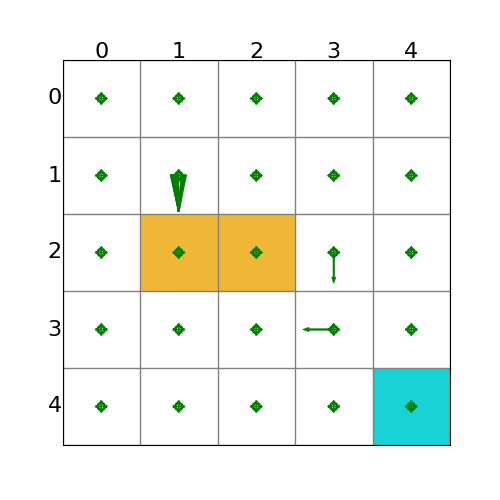

In [3]:

render = Render(target=[4, 4], forbidden=[np.array([1, 2]), np.array([2, 2])], size=5)
render.draw_action(pos=[3, 2], toward=(0, 0.4))
render.draw_action(pos=[3, 3], toward=(-0.4, 0))
# render.save_frame('test1')

for num in range(20):
    render.draw_random_line(pos1=[1, 1], pos2=[1, 2])

# for num in range(20):
#     render.draw_random_line(pos1=[1, 1], pos2=[1, 0])

# for num in range(20):
#     render.draw_random_line(pos1=[1, 1], pos2=[2, 1])

# for num in range(20):
#     render.draw_random_line(pos1=[1, 1], pos2=[0, 1])

action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
uniform_policy = np.random.random(size=(25, 5))
uniform_policy = np.ones(shape=(25, 5)) / 5
for state in range(25):
    for action in range(5):
        policy = uniform_policy[state, action]
        render.draw_action(pos=[state // 5, state % 5], toward=policy * 0.4 * action_to_direction[action],
                           radius=0.03 + 0.07 * policy)
for a in range(5):
    render.trajectory.append((a, a))

# render.fig.show()


In [4]:

import time
from typing import Optional, Union, List, Tuple

import gym
import numpy as np
from gym import spaces
from gym.core import RenderFrame, ActType, ObsType
np.random.seed(1)

def arr_in_list(array, _list):
    for element in _list:
        if np.array_equal(element, array):
            return True
    return False


class GridEnv(gym.Env):

    def __init__(self, size: int, target: Union[list, tuple, np.ndarray], forbidden: Union[list, tuple, np.ndarray],
                 render_mode: str):
        """
        GridEnv 的构造函数
        :param size: grid_world 的边长
        :param target: 目标点的pos
        :param forbidden: 不可通行区域 二维数组 或者嵌套列表 如 [[1,2],[2,2]]
        :param render_mode: 渲染模式 video表示保存视频
        """
        # 初始化可视化
        self.agent_location = np.array([0, 0])
        self.time_steps = 0
        self.size = size
        self.render_mode = render_mode
        self.render_ = Render(target=target, forbidden=forbidden, size=size)
        # 初始化起点 障碍物 目标点
        self.forbidden_location = []
        for fob in forbidden:
            self.forbidden_location.append(np.array(fob))
        self.target_location = np.array(target)
        # 初始化 动作空间 观测空间
        self.action_space, self.action_space_size = spaces.Discrete(5), spaces.Discrete(5).n
        self.reward_list = [0, 1, -10, -10]
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "barrier": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )
        # action to pos偏移量 的一个map
        # self.action_to_direction = {
        #     0: np.array([-1, 0]),
        #     1: np.array([0, 1]),
        #     2: np.array([1, 0]),
        #     3: np.array([0, -1]),
        #     4: np.array([0, 0]),
        # }

        self.action_to_direction = {
            0: np.array([0, -1]),
            1: np.array([1, 0]),
            2: np.array([0, 1]),
            3: np.array([-1, 0]),
            4: np.array([0, 0]),
        }
        
        # Rsa表示 在 指定 state 选取指点 action 得到reward的概率
        self.Rsa = None
        # Psa表示 在 指定 state 选取指点 action 跳到下一个state的概率
        self.Psa = None
        self.psa_rsa_init()

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None, ) -> Tuple[ObsType, dict]:
        super().reset(seed=seed)
        self.agent_location = np.array([0, 0])
        observation = self.get_obs()
        info = self.get_info()
        return observation, info

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, bool, dict]:

        reward = self.reward_list[self.Rsa[self.pos2state(self.agent_location), action].tolist().index(1)]
        direction = self.action_to_direction[action]
        self.render_.upgrade_agent(self.agent_location, direction, self.agent_location + direction)
        self.agent_location = np.clip(self.agent_location + direction, 0, self.size - 1)
        terminated = np.array_equal(self.agent_location, self.target_location)
        observation = self.get_obs()
        info = self.get_info()
        return observation, reward, terminated, False, info

    def render(self) -> Optional[Union[RenderFrame, List[RenderFrame]]]:
        if self.render_mode == "video":
            self.render_.save_video('image/' + str(time.time()))
        self.render_.show_frame(0.3)
        return None

    def get_obs(self) -> ObsType:
        return {"agent": self.agent_location, "target": self.target_location, "barrier": self.forbidden_location}

    def get_info(self) -> dict:
        return {"time_steps": self.time_steps}

    def state2pos(self, state: int) -> np.ndarray:
        # return np.array((state // self.size, state % self.size))
        return np.array((state % self.size, state // self.size))

    def pos2state(self, pos: np.ndarray) -> int:
        # return pos[0] * self.size + pos[1]
        return pos[1] * self.size + pos[0]

    def psa_rsa_init(self):
        """
        初始化网格世界的 psa 和 rsa
        赵老师在b站评论区回答过 关于 rsa设计的问题
        原问题是；
        B友：老师您好，在spinning up 7.2.5里有写到
        Reward depends on the current state of the world, the action just taken, and the next state of the world.
        但您提到Rewad depends on the state and action, but not the next state.不知道reward 和 next state的关系是怎样的？

        答案如下：
        赵老师：这是一个很细小、但是很好的问题，说明你思考了。也许其他人也会有这样的疑问，我来详细解答一下。
        1）从贝尔曼公式和数学的角度来说，r是由p(r|s,a)决定的，所以从数学的角度r依赖于s,a，而不依赖于下一个状态s’。这是很简明的。
        2）举例，如果在target state刚好旁边是墙，agent试图撞墙又弹回来target state，这时候不应该给正r，而应该是给负r，因为r依赖于a而不是下一个状态。
        3）但是r是否和s’无关呢？实际是有关系的，否则为什么每次进到target state要得到正r呢？不过，这也可以等价理解成是在之前那个状态采取了好的动作才得到了正r。
        总结：r确实和s’有关，但是这种关系被设计蕴含到了条件概率p(r|s,a)中去。
        故而这里的rsa蕴含了next_state的信息
        :return:
        """
        state_size = self.size ** 2
        self.Psa = np.zeros(shape=(state_size, self.action_space_size, state_size), dtype=float)
        self.Rsa = np.zeros(shape=(self.size ** 2, self.action_space_size, len(self.reward_list)), dtype=float)
        for state_index in range(state_size):
            for action_index in range(self.action_space_size):
                pos = self.state2pos(state_index)
                next_pos = pos + self.action_to_direction[action_index]
                if next_pos[0] < 0 or next_pos[1] < 0 or next_pos[0] > self.size - 1 or next_pos[1] > self.size - 1:
                    self.Psa[state_index, action_index, state_index] = 1
                    self.Rsa[state_index, action_index, 3] = 1

                else:
                    self.Psa[state_index, action_index, self.pos2state(next_pos)] = 1
                    if np.array_equal(next_pos, self.target_location):
                        self.Rsa[state_index, action_index, 1] = 1
                    elif arr_in_list(next_pos, self.forbidden_location):
                        self.Rsa[state_index, action_index, 2] = 1
                    else:
                        self.Rsa[state_index, action_index, 0] = 1

    def close(self):
        pass


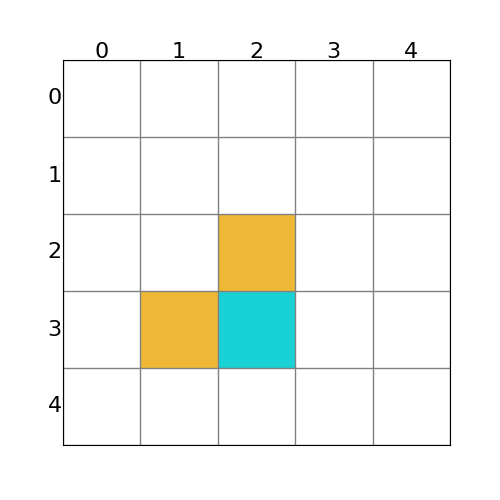

In [5]:

grid = GridEnv(size=5, target=[2, 3], forbidden=[[1, 3], [2, 2]], render_mode='')
# grid.render()


In [29]:

import random
import time

# import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

from tqdm import tqdm

class Solve:
    def __init__(self, env: GridEnv):
        self.gama = 0.9
        self.env = env
        self.action_space_size = env.action_space_size
        self.state_space_size = env.size ** 2
        self.reward_space_size, self.reward_list = len(self.env.reward_list), self.env.reward_list
        self.state_value = np.zeros(shape=self.state_space_size)
        self.qvalue = np.zeros(shape=(self.state_space_size, self.action_space_size))
        self.mean_policy = np.ones(shape=(self.state_space_size, self.action_space_size)) / self.action_space_size
        self.policy = self.mean_policy.copy()
        self.writer = SummaryWriter("logs")  # 实例化SummaryWriter对象

    def show_policy(self):
        for state in range(self.state_space_size):
            for action in range(self.action_space_size):
                policy = self.policy[state, action]
                self.env.render_.draw_action(pos=self.env.state2pos(state),
                                             toward=policy * 0.4 * self.env.action_to_direction[action],
                                             radius=policy * 0.1)

    def show_policy(self, policy):
        for state in range(self.state_space_size):
            for action in range(self.action_space_size):
                policy_cur = policy[state, action]
                self.env.render_.draw_action(pos=self.env.state2pos(state),
                                             toward=policy_cur * 0.4 * self.env.action_to_direction[action],
                                             radius=policy_cur * 0.1)
    
    def show_state_value(self, state_value, y_offset=0.2):
        for state in range(self.state_space_size):
            self.env.render_.write_word(pos=self.env.state2pos(state), word=str(round(state_value[state], 1)),
                                        y_offset=y_offset,
                                        size_discount=0.7)

    def get_state_value_by_policy(self, policy, epoch, gamma):
        """
            calculate p_pi
            iterate calculate v
        """
        ped = np.expand_dims(policy, axis=1)
        ps = np.matmul(ped, self.env.Psa).squeeze(1)

        policy_greedy = np.argmax(policy, axis=1)
        policy_greedy = np.expand_dims(policy_greedy, axis=1)

        self.env.reward_list = [0, 1, -1, -1]
        
        reward_immediate = [self.reward_list[np.argmax(self.env.Rsa[s, int(x)])] for s, x in enumerate(policy_greedy)]

        for i in range(epoch):
            self.state_value = reward_immediate + gamma * np.matmul(ps, self.state_value)
            
    def bellman_optimality_equation(self, epoch, gamma, policy=None):
        """
            Value Iteration
            Thinking: 1. calculate q(s,a) 2. select optimal pi -> update v(s)
        """

        self.env.reward_list = [0, 1, -10, -1]
        
        for i in range(epoch):
            qsa = np.matmul(self.env.Rsa, self.env.reward_list) + gamma * np.matmul(self.env.Psa, self.state_value)

            self.policy = np.eye(5, dtype=int)[np.argmax(qsa, axis=-1)]
            
            self.state_value = (self.policy * qsa).sum(axis=1)

    def mc_basic(self, epoch, gamma, episode=100, sample_nums=50):
        """
        
        """
        def sample_by_sa(env: GridEnv, policy, state_start, action_start, episode, sample_nums):

            rewards_all = []
            indices = np.arange(env.action_space_size)
            for _ in range(sample_nums):
                env.agent_location = state_start
                action = action_start
                rewards = []
    
                for i in range(episode):
                    _, reward, terminated, _, _ = env.step(action)

                    action_cur_probs = policy[env.pos2state(env.agent_location)]
                    action = np.random.choice(indices, p=action_cur_probs)
                    
                    rewards.append(reward)
    
                env.reset()

                rewards_all.append(rewards)
            return rewards_all

        self.env.reward_list = [0, 1, -10, -1]
        self.policy = np.eye(5, dtype=int)[[4]*self.state_space_size]
        gamma_sample_nums = gamma ** np.arange(sample_nums)
        for _ in tqdm(range(epoch), total=epoch):

            q_value_all = []
            # for i in tqdm(range(self.state_space_size), total=self.state_space_size, desc="states "):
            for i in range(self.state_space_size):
                state_cur = self.env.state2pos(i)

                q_value = []
                for j in range(self.action_space_size):
                    action_cur = j

                    rewards = sample_by_sa(self.env, self.policy, state_cur, action_cur, episode, sample_nums)

                    q_value.append(np.mean(rewards))
                    
                q_value_all.append(q_value)

            print(np.argmax(q_value_all[11]), q_value_all[11])
            self.policy = np.eye(5, dtype=int)[np.argmax(q_value_all, axis=-1)]

        self.get_state_value_by_policy(self.policy, 100, gamma)
        

  2%|█▋                                                                                  | 1/50 [00:11<09:40, 11.84s/it]

3 [np.float64(-10.0), np.float64(-10.0), np.float64(-10.0), np.float64(0.0), np.float64(0.0)]


  4%|███▎                                                                                | 2/50 [00:23<09:24, 11.76s/it]

1 [np.float64(-0.1), np.float64(0.89), np.float64(0.89), np.float64(0.0), np.float64(0.0)]


  6%|█████                                                                               | 3/50 [00:35<09:12, 11.76s/it]

1 [np.float64(-0.1), np.float64(0.89), np.float64(0.89), np.float64(0.0), np.float64(0.88)]


  8%|██████▋                                                                             | 4/50 [00:47<09:03, 11.80s/it]

1 [np.float64(0.77), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 10%|████████▍                                                                           | 5/50 [00:59<08:51, 11.82s/it]

1 [np.float64(0.77), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 12%|██████████                                                                          | 6/50 [01:20<11:10, 15.24s/it]

1 [np.float64(0.77), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 14%|███████████▊                                                                        | 7/50 [01:33<10:13, 14.28s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 16%|█████████████▍                                                                      | 8/50 [01:45<09:30, 13.58s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 18%|███████████████                                                                     | 9/50 [01:57<09:00, 13.19s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 20%|████████████████▌                                                                  | 10/50 [02:09<08:29, 12.73s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 22%|██████████████████▎                                                                | 11/50 [02:20<08:03, 12.41s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 24%|███████████████████▉                                                               | 12/50 [02:33<07:52, 12.43s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 26%|█████████████████████▌                                                             | 13/50 [02:45<07:30, 12.17s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 28%|███████████████████████▏                                                           | 14/50 [02:56<07:11, 11.97s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 30%|████████████████████████▉                                                          | 15/50 [03:08<07:02, 12.08s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 32%|██████████████████████████▌                                                        | 16/50 [03:20<06:44, 11.91s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 34%|████████████████████████████▏                                                      | 17/50 [03:31<06:29, 11.81s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 36%|█████████████████████████████▉                                                     | 18/50 [03:43<06:16, 11.76s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 38%|███████████████████████████████▌                                                   | 19/50 [03:55<06:02, 11.70s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 40%|█████████████████████████████████▏                                                 | 20/50 [04:07<06:00, 12.02s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 42%|██████████████████████████████████▊                                                | 21/50 [04:19<05:43, 11.86s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 44%|████████████████████████████████████▌                                              | 22/50 [04:31<05:34, 11.93s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 46%|██████████████████████████████████████▏                                            | 23/50 [04:43<05:19, 11.83s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 48%|███████████████████████████████████████▊                                           | 24/50 [04:54<05:07, 11.81s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 50%|█████████████████████████████████████████▌                                         | 25/50 [05:06<04:53, 11.73s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 52%|███████████████████████████████████████████▏                                       | 26/50 [05:19<04:50, 12.12s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 54%|████████████████████████████████████████████▊                                      | 27/50 [05:30<04:34, 11.94s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 56%|██████████████████████████████████████████████▍                                    | 28/50 [05:42<04:20, 11.84s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 58%|████████████████████████████████████████████████▏                                  | 29/50 [05:54<04:07, 11.77s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 60%|█████████████████████████████████████████████████▊                                 | 30/50 [06:05<03:53, 11.68s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 62%|███████████████████████████████████████████████████▍                               | 31/50 [06:17<03:40, 11.60s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 64%|█████████████████████████████████████████████████████                              | 32/50 [06:28<03:29, 11.66s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 66%|██████████████████████████████████████████████████████▊                            | 33/50 [06:40<03:18, 11.66s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 68%|████████████████████████████████████████████████████████▍                          | 34/50 [06:53<03:14, 12.15s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 70%|██████████████████████████████████████████████████████████                         | 35/50 [07:05<02:59, 12.00s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 72%|███████████████████████████████████████████████████████████▊                       | 36/50 [07:17<02:46, 11.90s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 74%|█████████████████████████████████████████████████████████████▍                     | 37/50 [07:28<02:33, 11.83s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 76%|███████████████████████████████████████████████████████████████                    | 38/50 [07:40<02:21, 11.82s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 78%|████████████████████████████████████████████████████████████████▋                  | 39/50 [07:52<02:09, 11.76s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 80%|██████████████████████████████████████████████████████████████████▍                | 40/50 [08:03<01:57, 11.72s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 82%|████████████████████████████████████████████████████████████████████               | 41/50 [08:15<01:44, 11.66s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 84%|█████████████████████████████████████████████████████████████████████▋             | 42/50 [08:27<01:33, 11.66s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 86%|███████████████████████████████████████████████████████████████████████▍           | 43/50 [08:41<01:26, 12.36s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 88%|█████████████████████████████████████████████████████████████████████████          | 44/50 [08:52<01:12, 12.15s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 45/50 [09:04<01:00, 12.00s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 92%|████████████████████████████████████████████████████████████████████████████▎      | 46/50 [09:16<00:47, 11.90s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 94%|██████████████████████████████████████████████████████████████████████████████     | 47/50 [09:27<00:35, 11.77s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 48/50 [09:39<00:23, 11.76s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [09:50<00:11, 11.74s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [10:02<00:00, 12.05s/it]

1 [np.float64(0.79), np.float64(0.89), np.float64(0.89), np.float64(0.87), np.float64(0.88)]



/tmp/ipykernel_3174/773255001.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_immediate = [self.reward_list[np.argmax(self.env.Rsa[s, int(x)])] for s, x in enumerate(policy_greedy)]


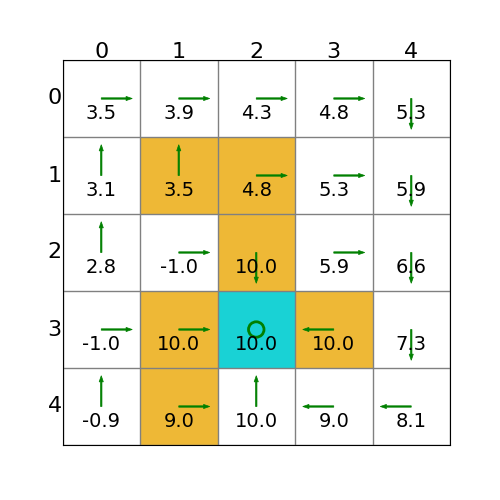

In [30]:

grid_env = GridEnv(size=5, target=[2, 3],
             forbidden=[[2, 2], [2, 1], [1, 1], [3, 3], [1, 3], [1, 4]],
             render_mode='')

solver = Solve(grid_env)

solver.mc_basic(
    epoch=50, 
    gamma=0.9,
    sample_nums=30
)

solver.show_policy(solver.policy)

solver.show_state_value(solver.state_value)



/tmp/ipykernel_4767/3459085321.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_immediate = [self.reward_list[np.argmax(self.env.Rsa[s, int(x)])] for s, x in enumerate(policy_greedy)]


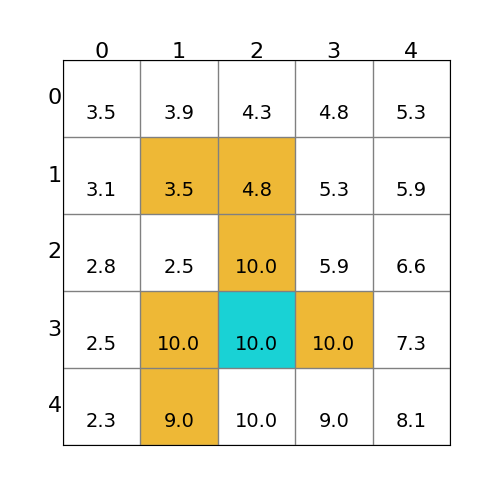

In [8]:

grid_env = GridEnv(size=5, target=[2, 3],
             forbidden=[[2, 2], [2, 1], [1, 1], [3, 3], [1, 3], [1, 4]],
             render_mode='')

policy_greedy = np.array(
    [[1,1,1,2,2],
    [0,0,1,2,2],
    [0,3,2,1,2],
    [0,1,4,3,2],
    [0,1,0,3,3]]
)

policy = np.eye(5, dtype=int)[policy_greedy.reshape(25)]

solver = Solve(grid_env)

solver.get_state_value_by_policy(
    policy=policy, 
    epoch=100, 
    gamma=0.9
)

# solver.show_policy(policy)

solver.show_state_value(solver.state_value)


/tmp/ipykernel_4762/3448437530.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_immediate = [self.reward_list[np.argmax(self.env.Rsa[s, int(x)])] for s, x in enumerate(policy_greedy)]


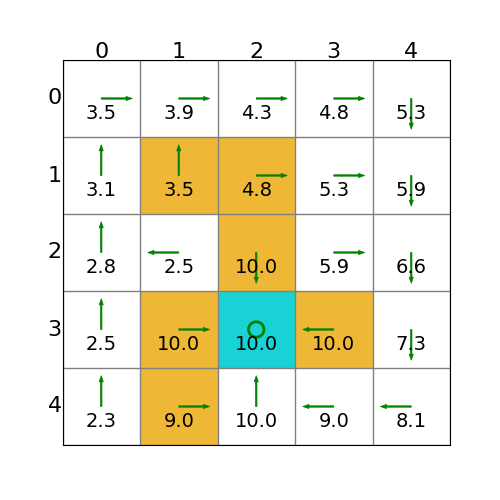

In [20]:

grid_env = GridEnv(size=5, target=[2, 3],
             forbidden=[[2, 2], [2, 1], [1, 1], [3, 3], [1, 3], [1, 4]],
             render_mode='')

policy_greedy = np.array(
    [[1,1,1,1,2],
    [0,0,1,1,2],
    [0,3,2,1,2],
    [0,1,4,3,2],
    [0,1,0,3,3]]
)

policy = np.eye(5, dtype=int)[policy_greedy.reshape(25)]

solver = Solve(grid_env)

solver.get_state_value_by_policy(
    policy=policy, 
    epoch=100, 
    gamma=0.9
)

solver.show_policy(policy)

solver.show_state_value(solver.state_value)


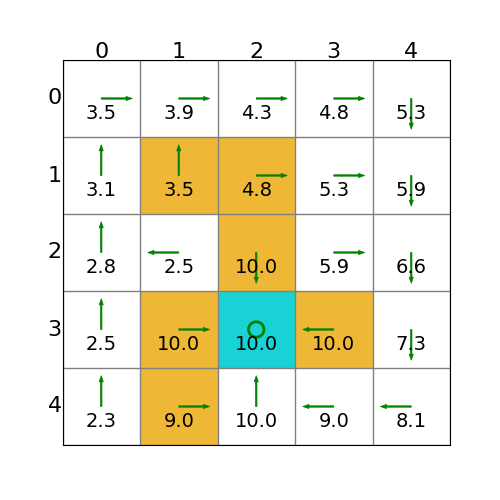

In [17]:

grid_env = GridEnv(size=5, target=[2, 3],
             forbidden=[[2, 2], [2, 1], [1, 1], [3, 3], [1, 3], [1, 4]],
             render_mode='')

solver = Solve(grid_env)

solver.bellman_optimality_equation(
    epoch=100, 
    gamma=0.9
)

solver.show_policy(solver.policy)

solver.show_state_value(solver.state_value)



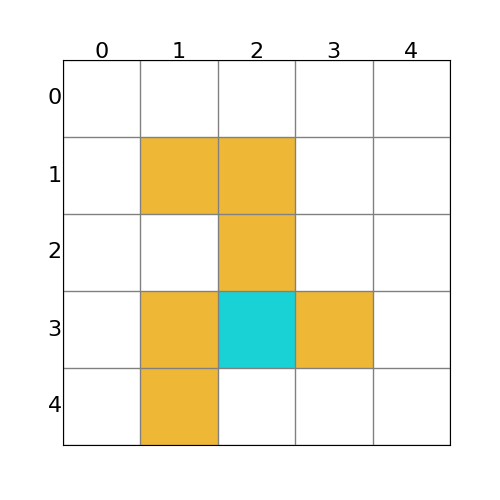

In [13]:

grid_env = GridEnv(size=5, target=[2, 3],
             forbidden=[[2, 2], [2, 1], [1, 1], [3, 3], [1, 3], [1, 4]],
             render_mode='')

solver = Solve(grid_env)


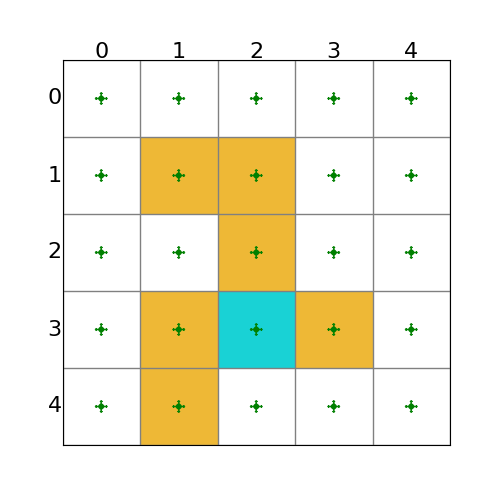

In [7]:

solver.show_policy()
solver.env.render()


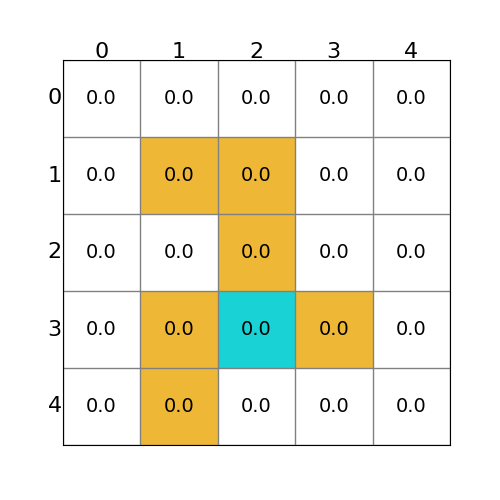

In [14]:

solver.show_state_value(solver.state_value, y_offset=0)
solver.env.render()


In [17]:
import numpy as np
np.random.choice(5)


0